In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter

import catboost
from catboost import CatBoostClassifier
import lightgbm as lgb
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

# Reading Data

In [3]:
path = '/home/ricardo/TCC/'

In [4]:
df = pd.read_csv(path+'train.csv', sep = ',')
X = df.loc[:,'var_0':'var_199']
Y = df.loc[:,'target']

# Normalizing Data

In [5]:
meanX = X.mean(axis = 0)
stdX = X.std(axis = 0)
X_norm = (X-meanX)/stdX

# Separating the Data in anomaly and not anomaly

In [6]:
fraud_index = np.where(Y==1)
honest_index = np.where(Y==0)
fraud = X_norm.loc[fraud_index]
honest = X_norm.loc[honest_index]

yh = Y.loc[honest_index]
yf = Y.loc[fraud_index]

# Balanced Data

### Verifying how unbalanced is our dataset

Text(0.5, 1.0, '8.951238929246692')

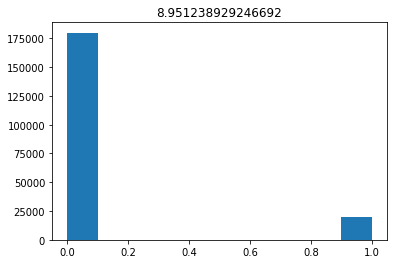

In [7]:
plt.hist(Y)
plt.title(len(yh)/len(yf))

### To balance the data we will eliminate some not anomaly samples

In [8]:
h_used, x_trash, yh, y_trash = train_test_split(honest, yh, test_size = 0.75, random_state = 30)
x_used = pd.concat([h_used,fraud],ignore_index = False)
y_used = pd.concat([yh,yf],ignore_index=False)

### Verifying if it is balanced now

Text(0.5, 1.0, '2.2377848542143495')

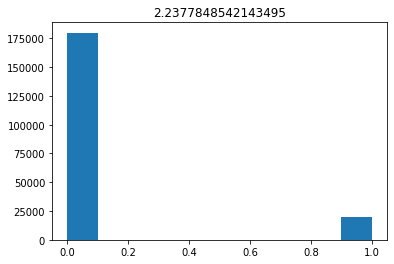

In [9]:
plt.hist(Y)
plt.title(len(yh)/len(yf))

# Separating in Train, Val and Test data

In [10]:
x_train,x_test,y_train,y_test = train_test_split(x_used,y_used,test_size=0.3,random_state = 30)
x_val,x_test,y_val,y_test = train_test_split(x_test,y_test,test_size=0.5,random_state = 30)

In [11]:
x_data = [x_train,x_val,x_test]
y_data = [y_train,y_val,y_test]

### Verifying the size of each dataframe

In [12]:
print('Resampled dataset shape %s' % Counter(y_train))
print('Resampled dataset shape %s' % Counter(y_test))
print('Resampled dataset shape %s' % Counter(y_val))

Resampled dataset shape Counter({0: 31412, 1: 14139})
Resampled dataset shape Counter({0: 6784, 1: 2977})
Resampled dataset shape Counter({0: 6779, 1: 2982})


# Importing some metrics to evaluating the models.

In [13]:
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# CatBoostClassifier

In [14]:
model = CatBoostClassifier(iterations=5000,eval_metric= 'F1',random_seed=42,verbose=False)
model.fit(x_data[0],y_data[0])

In [18]:
# model.save_model(path+'/Undersampling/Boost/CatBoostClassifier')

- ###  Analysing the performance with differents thresholds

In [15]:
def choosing_threshold(y_true,y_prob,threshold_list):
    y_hat = []
    precision = []
    recall = []
    f1 = []
    y_h = []
    for threshold in threshold_list:
        for i in range(len(y_true)):
            if y_prob[i]>threshold:
                y_hat.append(1)
            else:
                y_hat.append(0)
        precision.append(precision_score(y_true,y_hat))
        recall.append(recall_score(y_true,y_hat))
        f1.append(f1_score(y_true,y_hat))
        y_h.append(y_hat)
        y_hat = []
    return(precision,recall,f1,y_h)                       

In [16]:
def predict_threshold(y_prob,threshold):
    y_hat = []
    for i in range(len(y_prob)):
        if y_prob[i]>threshold:
            y_hat.append(1)
        else:
            y_hat.append(0)
    return y_hat

precision values: [0.44140699070855194, 0.45777587850498014, 0.4749427017411829, 0.490314340452707, 0.5066617592933382, 0.5227567279103453, 0.537594577553594, 0.5528713193427688, 0.5682037916684182, 0.5833044533009877, 0.5980094617513166, 0.6136489224534906, 0.6280976072020849, 0.6420132786565124, 0.6555667001003009, 0.6707978311386522, 0.6829875079398687, 0.6955272431553267, 0.7067251624368301, 0.7190717251578409, 0.7327269546965192, 0.744384707287933, 0.7559753041139434, 0.7657128576783706, 0.7752393107849394, 0.786353833082805, 0.7966452820101577, 0.8048680711802004, 0.8146392471244336, 0.8250017827854239, 0.8338421282163105, 0.8418435505417842, 0.8499356109385653, 0.8587124729186011, 0.8658979624072026, 0.8732655695385608, 0.8805368022394204, 0.8882347994281389, 0.8948768557453016, 0.9003153468815698, 0.9061801270011627, 0.9103044710615342, 0.9164407888587719, 0.9201372343467074, 0.9266627657499512, 0.9326280067871044, 0.9376341887332583, 0.9411887600543194, 0.9454019912214966, 0.9

Normalized confusion matrix
[[0.96100216 0.03899784]
 [0.26246552 0.73753448]]
Normalized confusion matrix
[[0.96377181 0.03622819]
 [0.27307447 0.72692553]]
Normalized confusion matrix
[[0.96660512 0.03339488]
 [0.28340052 0.71659948]]
Normalized confusion matrix
[[0.9687699  0.0312301 ]
 [0.29584836 0.70415164]]
Normalized confusion matrix
[[0.97153954 0.02846046]
 [0.30652804 0.69347196]]
Normalized confusion matrix
[[0.9733223 0.0266777]
 [0.317137  0.682863 ]]
Normalized confusion matrix
[[0.9760601  0.0239399 ]
 [0.32795813 0.67204187]]
Normalized confusion matrix
[[0.9785114  0.0214886 ]
 [0.33913289 0.66086711]]
Normalized confusion matrix
[[0.98058067 0.01941933]
 [0.35136856 0.64863144]]
Normalized confusion matrix
[[0.98207691 0.01792309]
 [0.3627555  0.6372445 ]]
Normalized confusion matrix
[[0.98376417 0.01623583]
 [0.37541552 0.62458448]]
Normalized confusion matrix
[[0.98519674 0.01480326]
 [0.38574157 0.61425843]]
Normalized confusion matrix
[[0.98640647 0.01359353]
 [0

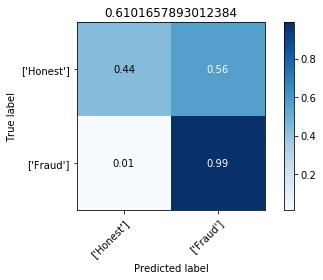

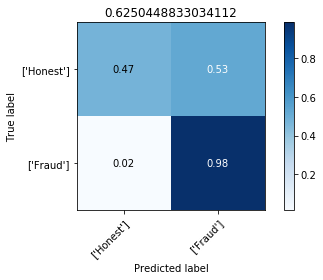

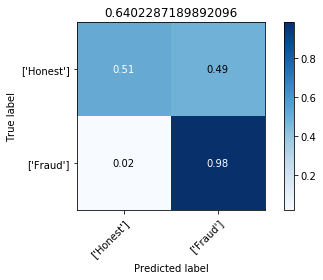

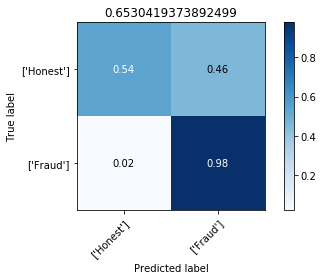

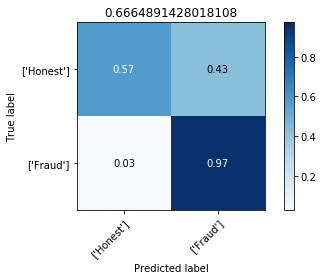

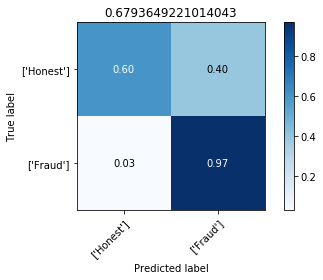

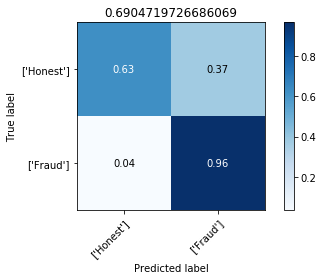

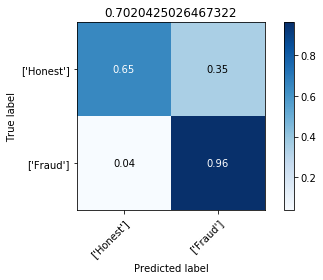

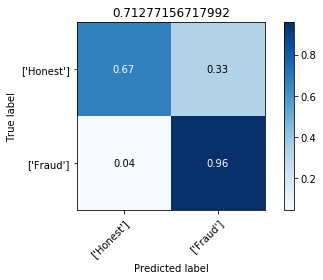

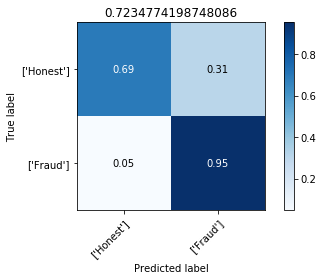

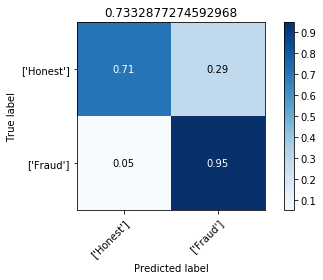

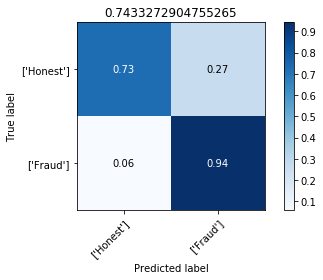

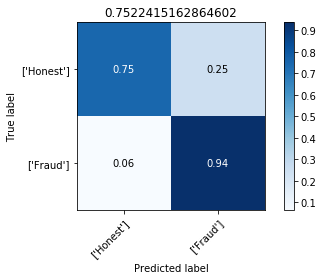

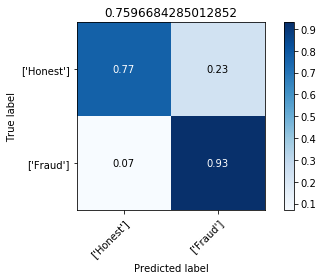

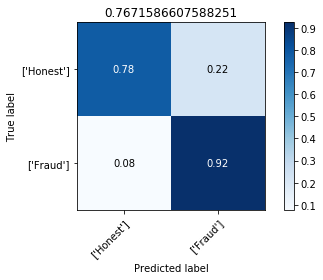

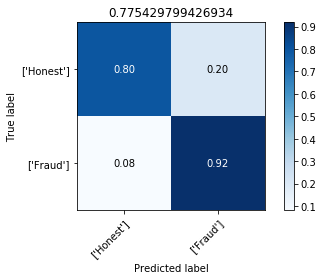

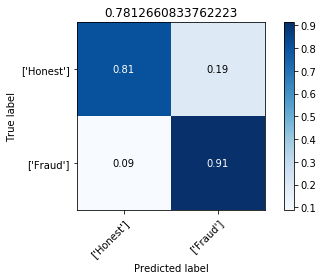

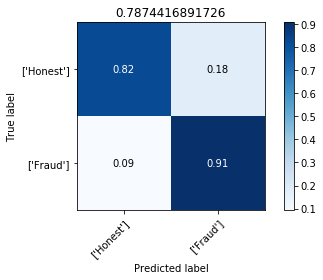

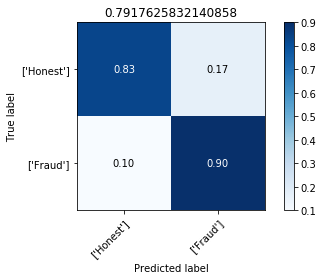

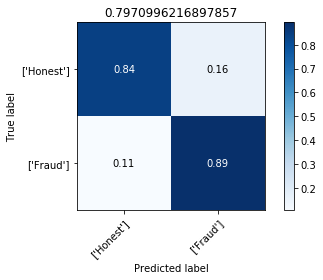

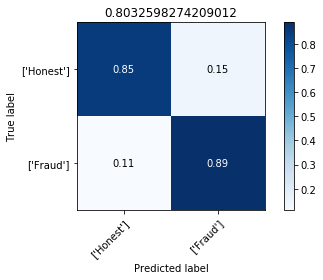

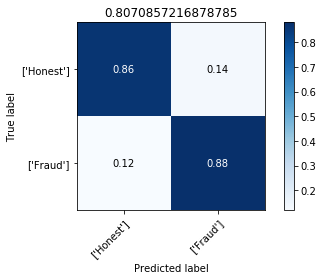

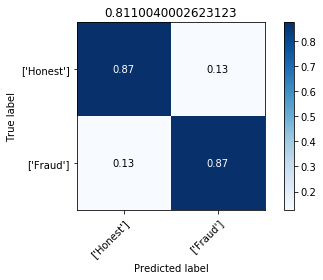

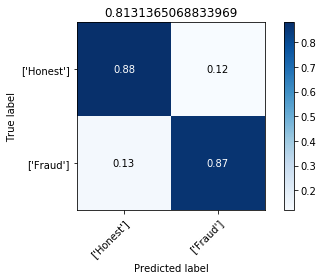

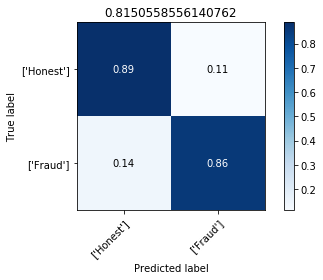

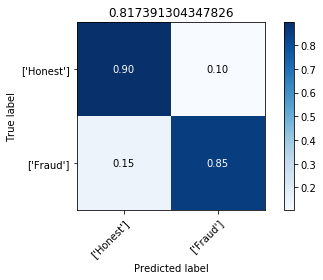

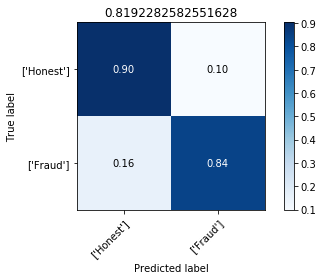

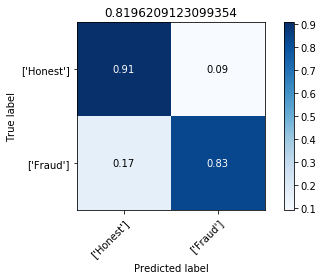

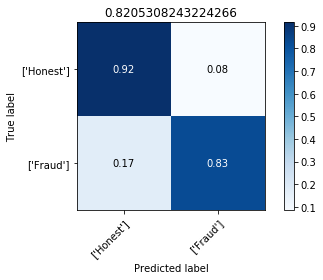

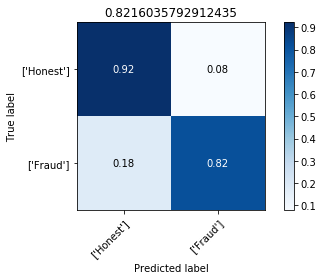

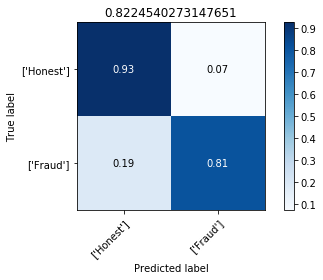

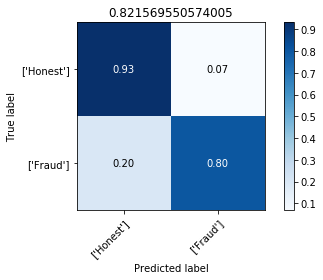

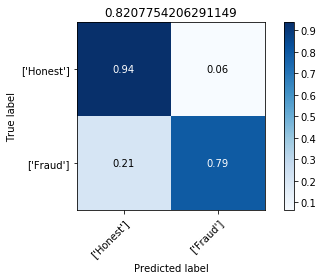

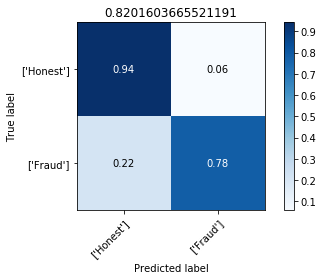

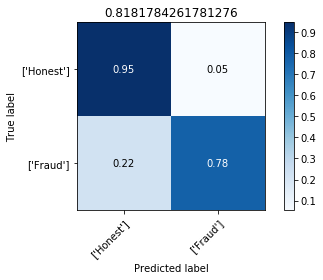

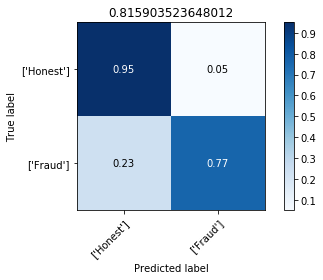

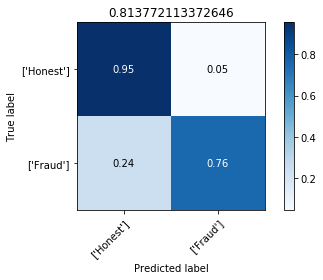

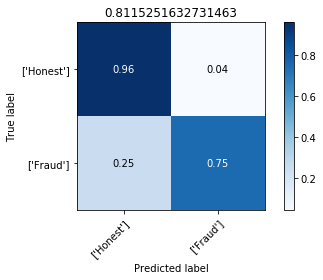

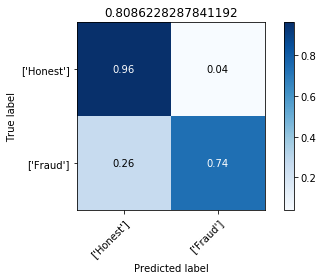

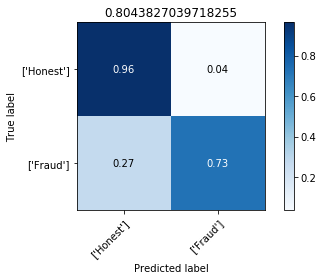

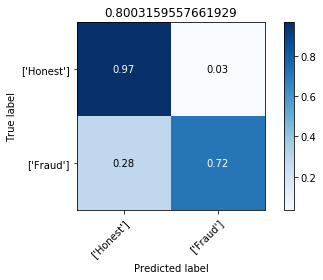

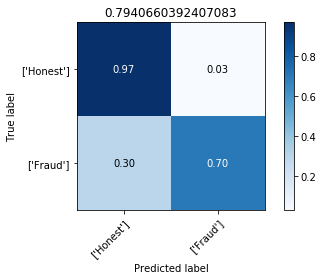

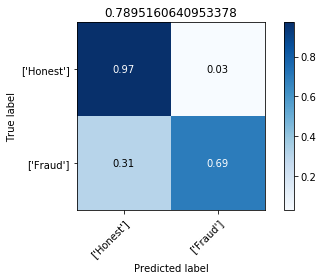

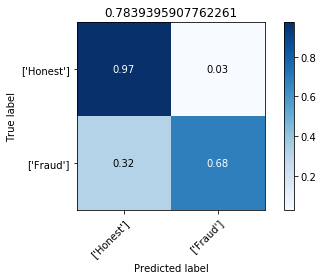

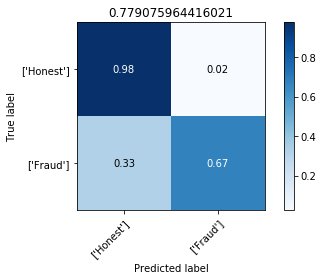

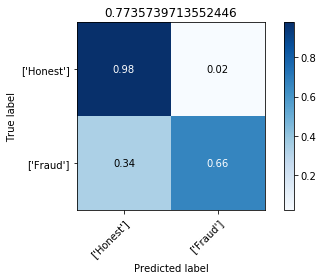

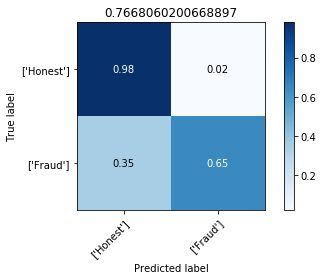

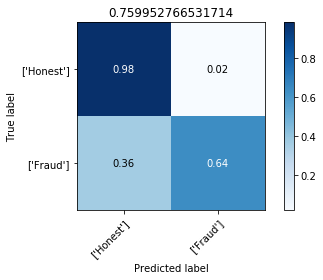

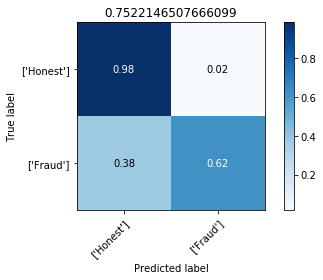

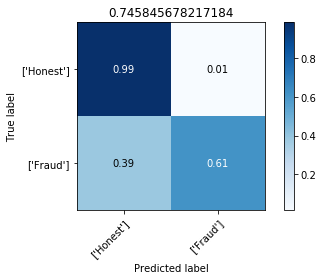

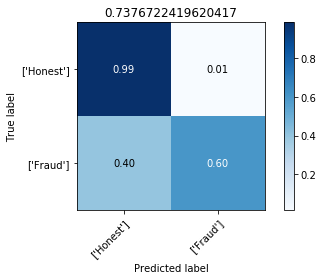

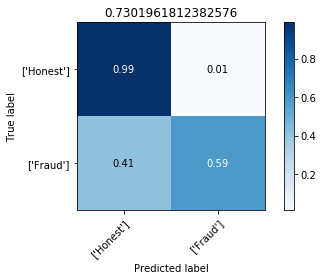

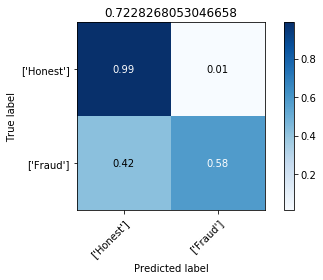

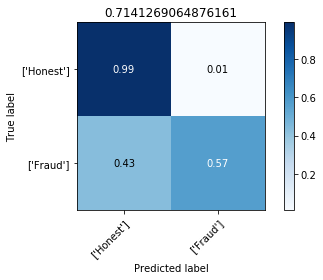

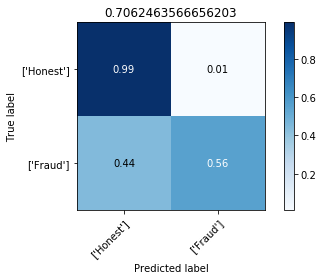

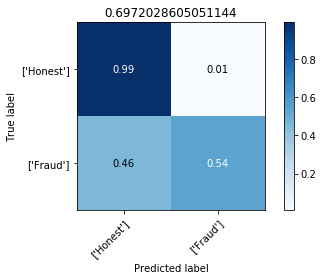

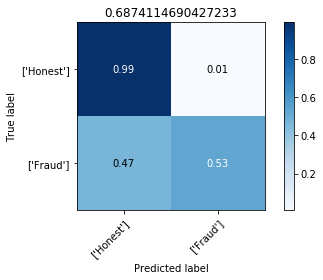

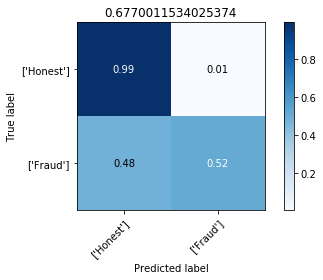

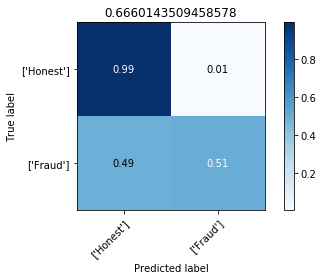

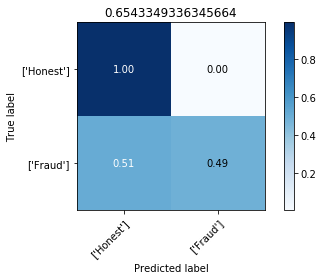

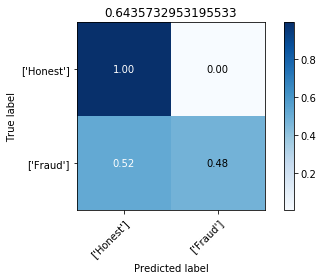

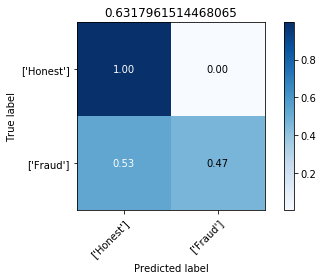

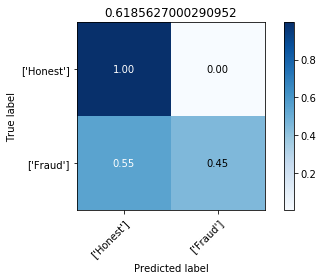

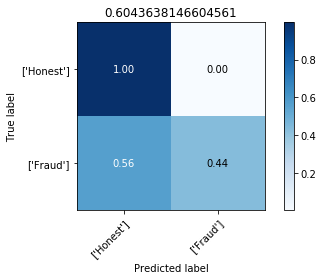

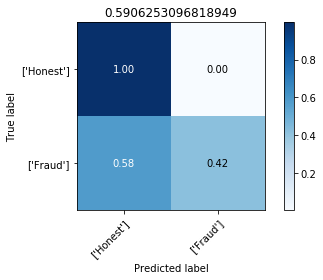

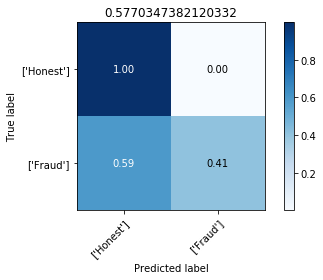

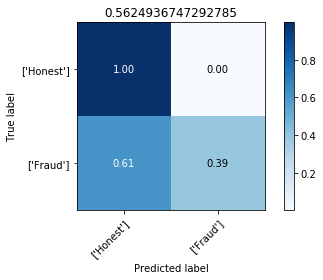

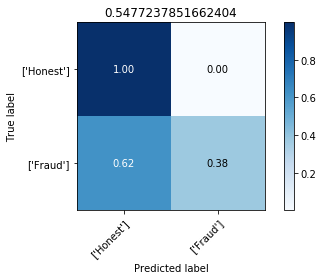

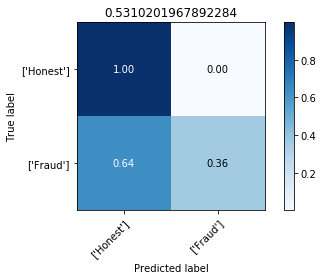

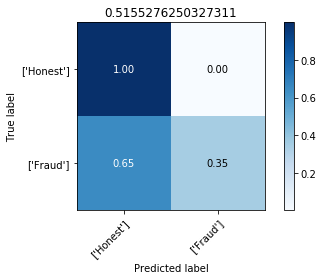

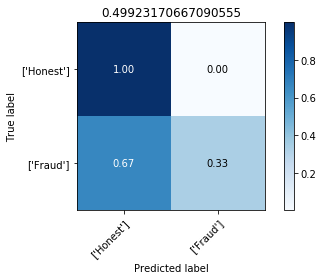

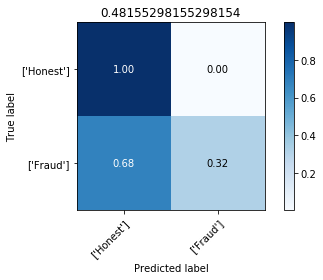

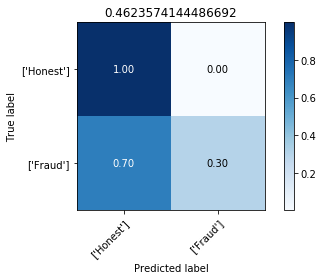

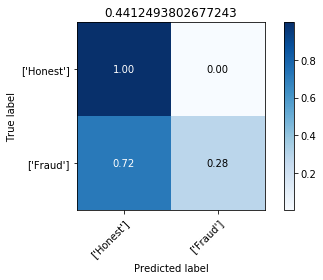

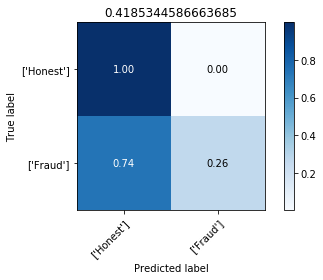

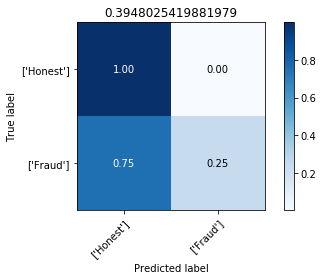

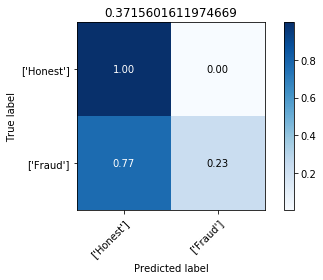

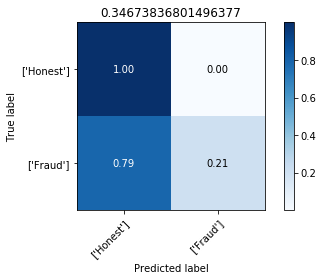

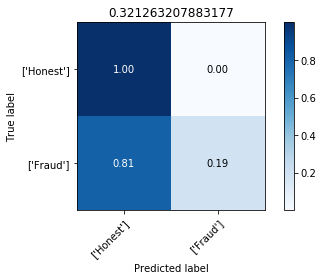

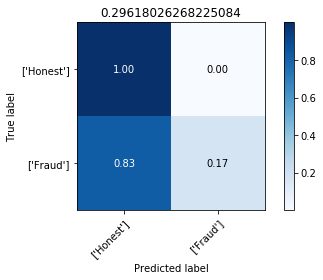

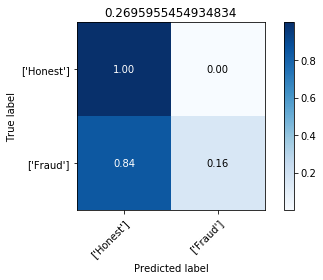

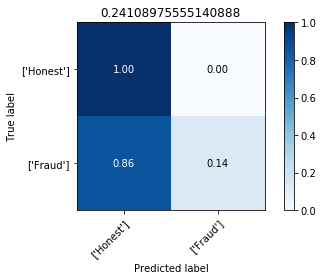

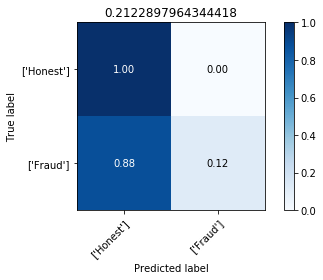

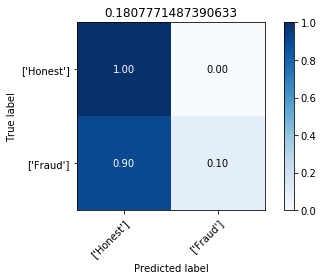

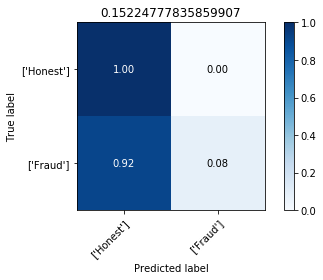

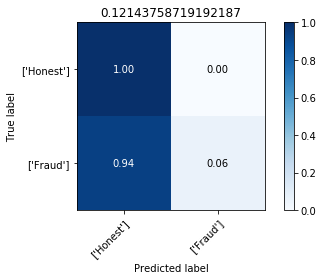

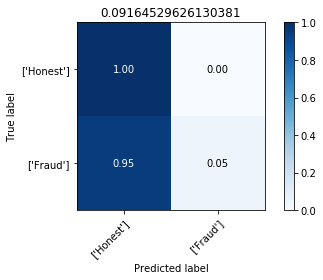

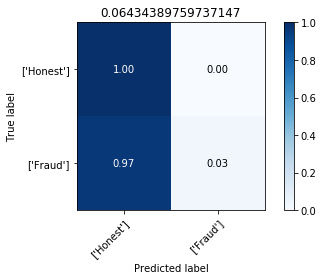

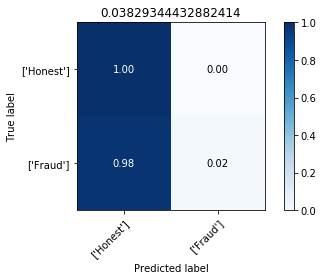

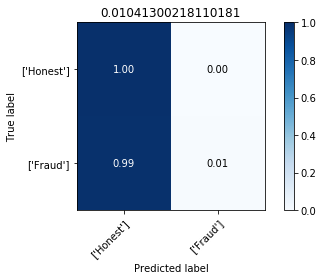

In [17]:
prob = np.ravel(model.predict_proba(x_data[0])[:,1])
threshold_list = np.arange(0.1,1,0.01)
precision,recall,f1,yprob = choosing_threshold(y_data[0],prob,threshold_list)

print('precision values: {}'.format(precision))
print('recall values: {}'.format(recall))
print('f1 values: {}'.format(f1))

for i in range(len(yprob)):
    plot_confusion_matrix(y_data[0], yprob[i],
                          classes = np.array([['Honest'],['Fraud']]),
                          normalize=True,
                          title= f1[i],
                          cmap=plt.cm.Blues)

- ### Predicting with the best Threshold

In [18]:
y_hat = []
for i in range(len(x_data)):
    y_hat.append(predict_threshold(np.ravel(model.predict_proba(x_data[i])[:,1]),
                                   threshold_list[f1.index(max(f1))]))

Normalized confusion matrix
[[0.92722526 0.07277474]
 [0.1886272  0.8113728 ]]
Normalized confusion matrix
[[0.87653046 0.12346954]
 [0.28001341 0.71998659]]
Normalized confusion matrix
[[0.88369693 0.11630307]
 [0.28115553 0.71884447]]


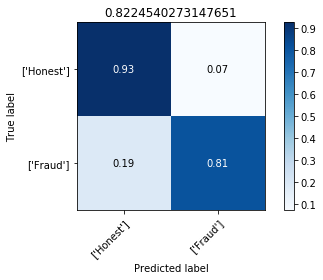

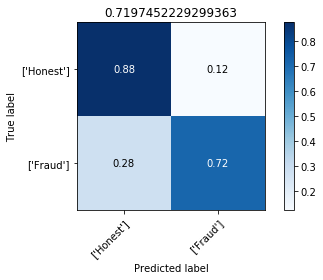

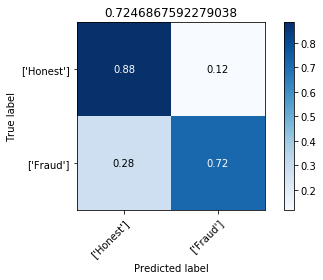

In [19]:
for i in range(len(y_hat)):
    plot_confusion_matrix(y_data[i], y_hat[i],
                          classes = np.array([['Honest'],['Fraud']]),
                          normalize=True,
                          title= f1_score(y_data[i],y_hat[i]),
                          cmap=plt.cm.Blues)

In [24]:
model = CatBoostClassifier(iterations=2000,eval_metric= 'F1',random_seed=42,verbose=False)
model.fit(x_data[0],y_data[0])

precision values: [0.43358271505292895, 0.4505046583850932, 0.46712430176997105, 0.4819822959503729, 0.4977755271819727, 0.5140884703410498, 0.5295670743544942, 0.5442321586256723, 0.5589076291906676, 0.5743879472693032, 0.5895624530884366, 0.6051684061802106, 0.6194607268464244, 0.6339553321086725, 0.6479426837156077, 0.6615549762306395, 0.6752810169135414, 0.68697150859051, 0.7003480470692227, 0.712263616804439, 0.7238658777120316, 0.7355455300961653, 0.7470194647201946, 0.7590444111776448, 0.7696231588344067, 0.7795306388526727, 0.789757951590318, 0.7985288107887208, 0.8071870438590394, 0.8168693549534173, 0.8261596626435946, 0.8353667608986758, 0.8440136830102623, 0.8516906335017489, 0.8590833267137977, 0.8658556366585564, 0.8747610737139533, 0.8815588385124808, 0.8882817243472981, 0.8957724009571922, 0.9016096943389401, 0.90625, 0.912743429759879, 0.9179645932088614, 0.9232295179527872, 0.927150974025974, 0.9329661193099148, 0.9380116959064327, 0.942410083668369, 0.946512146200133

Normalized confusion matrix
[[0.95899656 0.04100344]
 [0.27569135 0.72430865]]
Normalized confusion matrix
[[0.96256208 0.03743792]
 [0.28516868 0.71483132]]
Normalized confusion matrix
[[0.96536356 0.03463644]
 [0.29485819 0.70514181]]
Normalized confusion matrix
[[0.96771934 0.03228066]
 [0.30674022 0.69325978]]
Normalized confusion matrix
[[0.97061632 0.02938368]
 [0.317137   0.682863  ]]
Normalized confusion matrix
[[0.97300395 0.02699605]
 [0.32887757 0.67112243]]
Normalized confusion matrix
[[0.97535974 0.02464026]
 [0.34167904 0.65832096]]
Normalized confusion matrix
[[0.97714249 0.02285751]
 [0.35370252 0.64629748]]
Normalized confusion matrix
[[0.97946645 0.02053355]
 [0.36508947 0.63491053]]
Normalized confusion matrix
[[0.98144021 0.01855979]
 [0.37605205 0.62394795]]
Normalized confusion matrix
[[0.98312747 0.01687253]
 [0.38659028 0.61340972]]
Normalized confusion matrix
[[0.98471922 0.01528078]
 [0.3992503  0.6007497 ]]
Normalized confusion matrix
[[0.98605628 0.01394372]

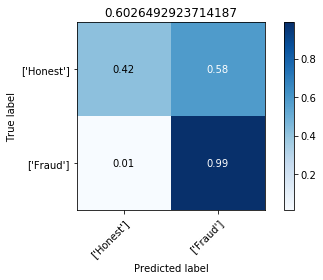

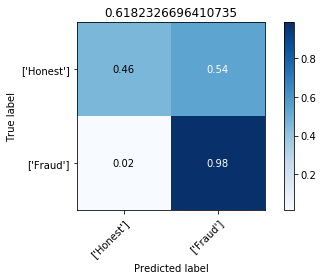

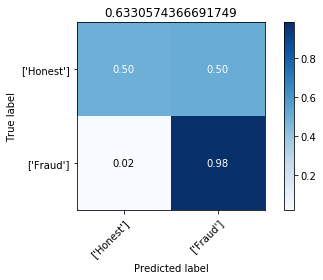

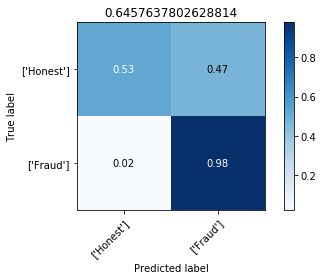

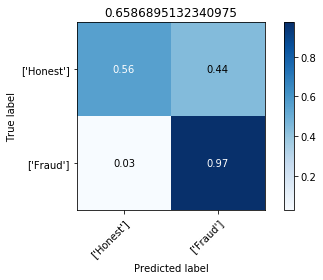

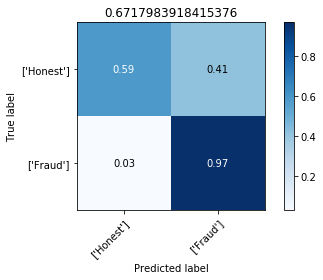

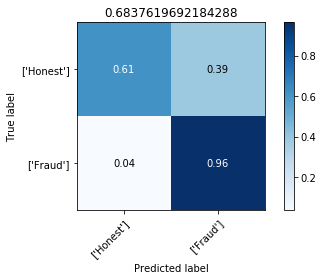

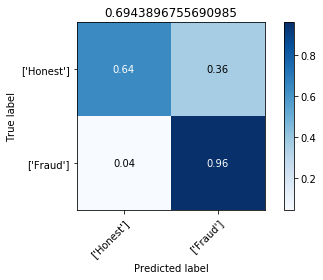

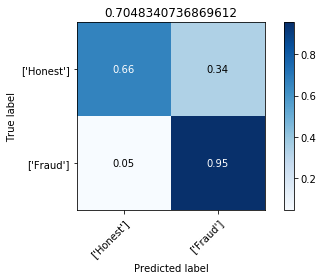

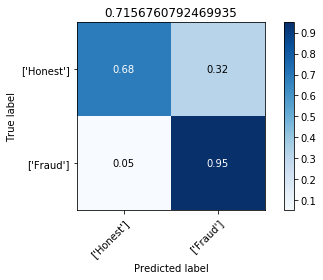

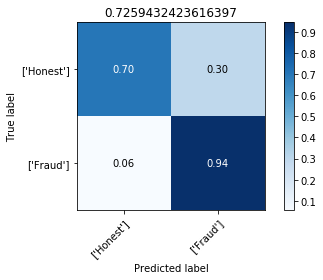

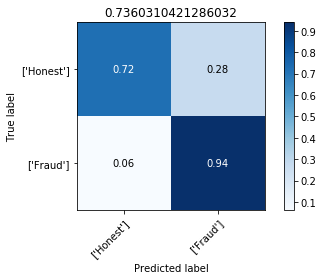

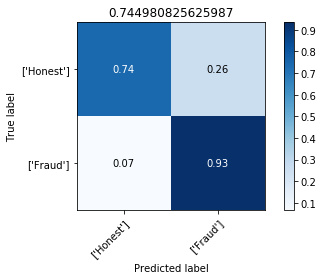

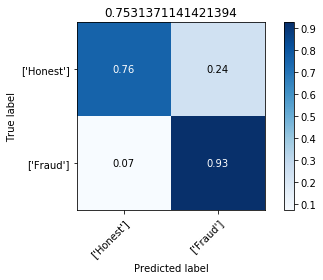

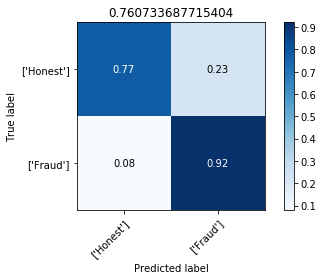

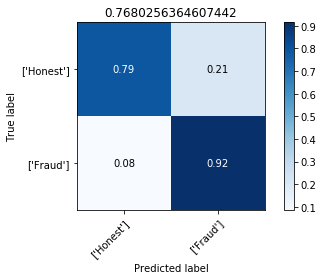

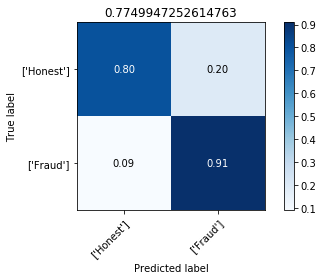

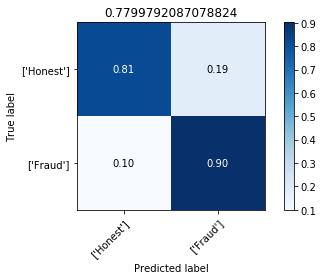

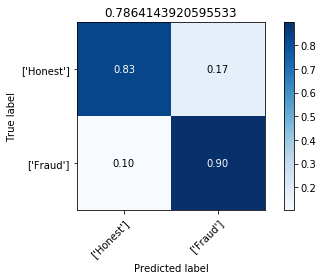

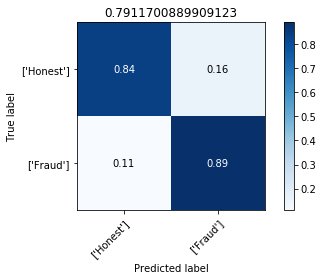

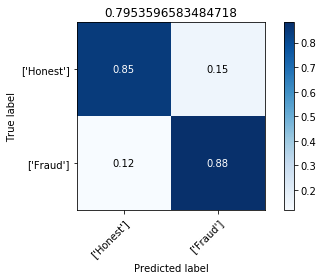

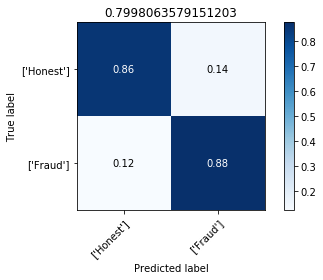

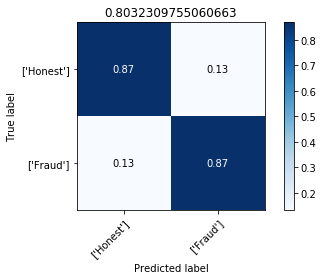

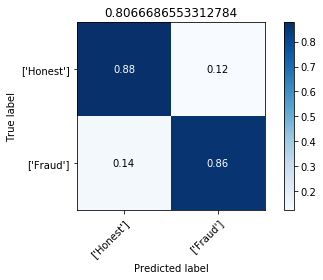

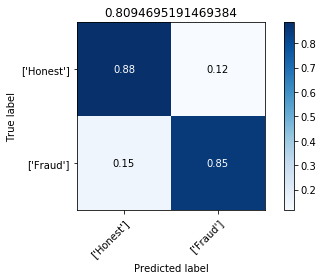

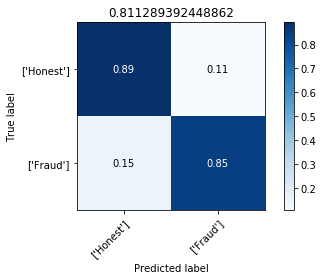

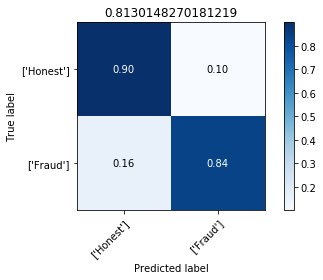

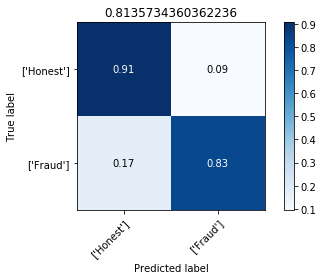

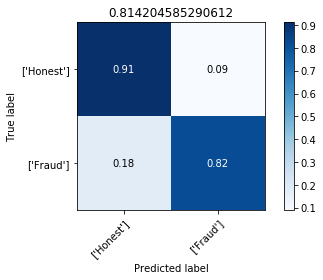

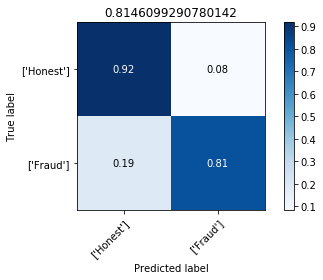

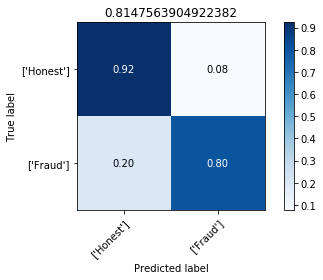

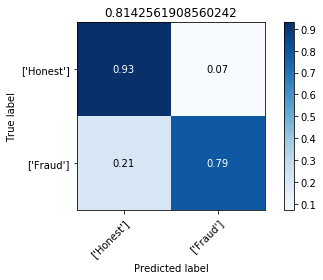

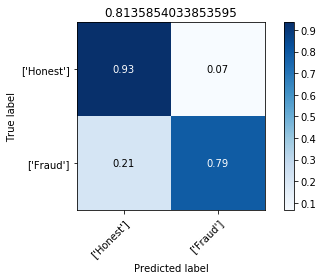

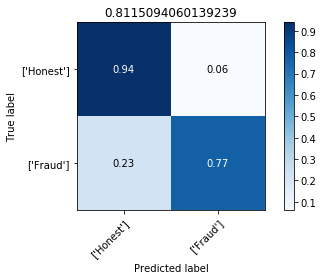

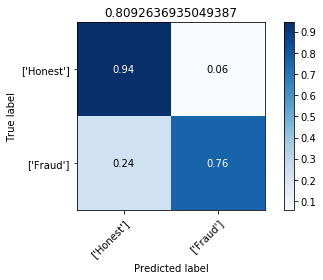

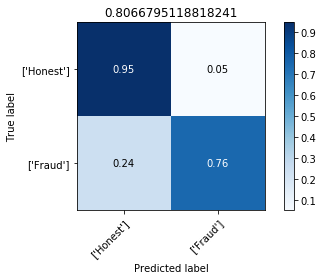

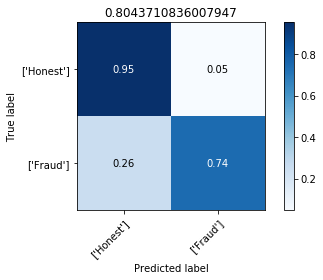

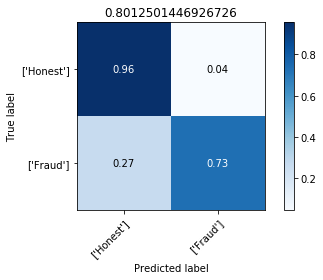

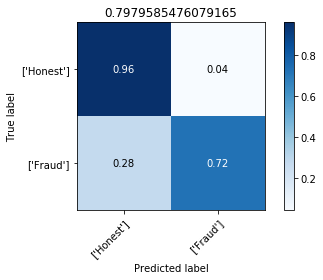

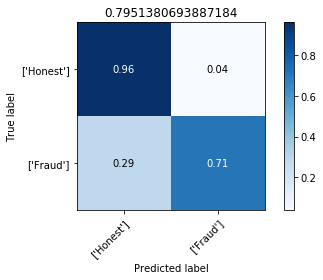

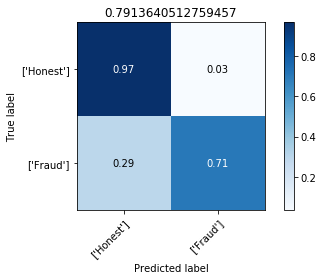

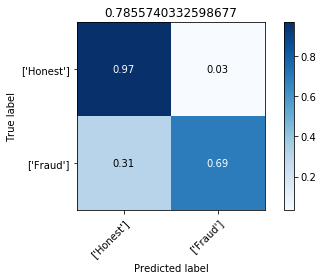

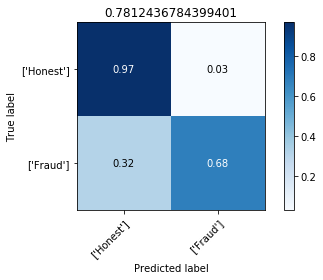

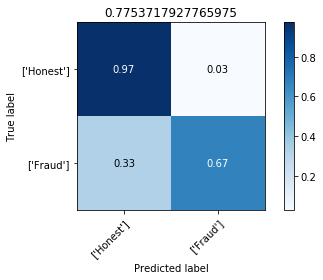

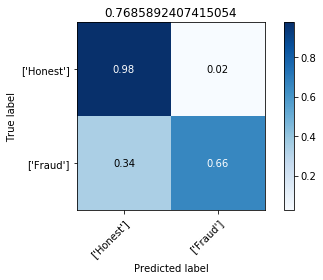

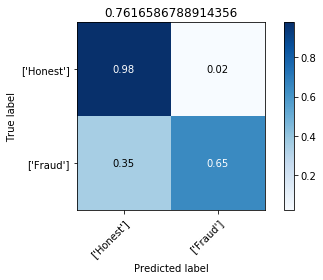

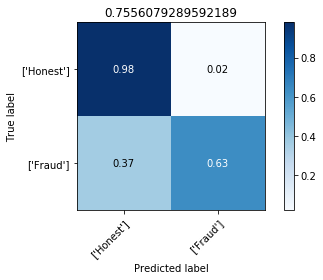

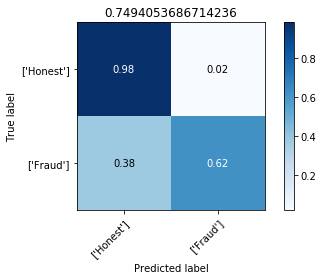

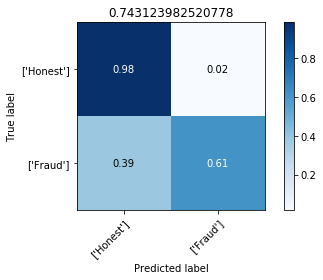

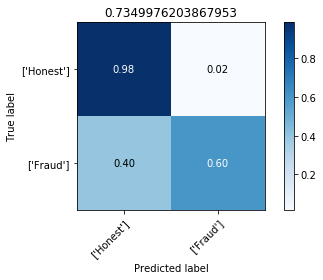

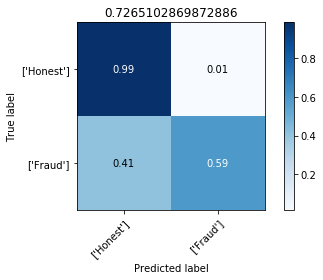

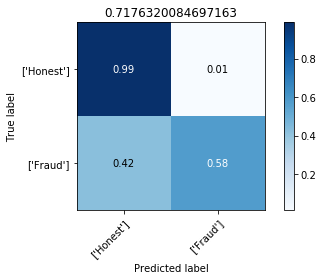

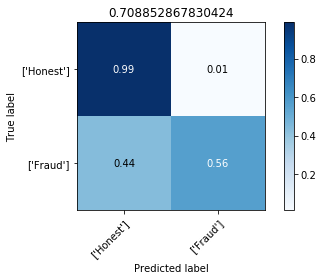

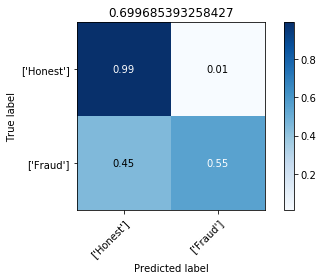

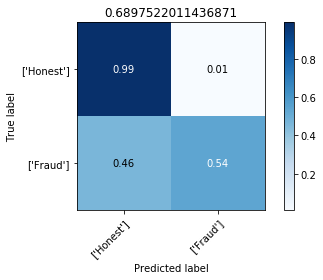

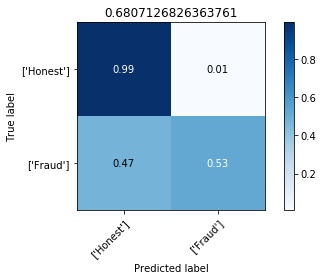

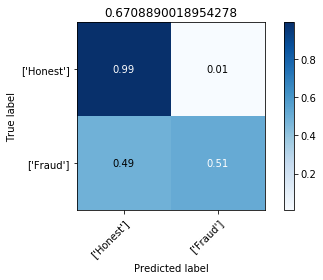

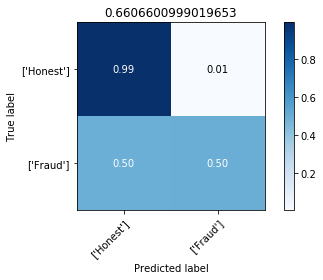

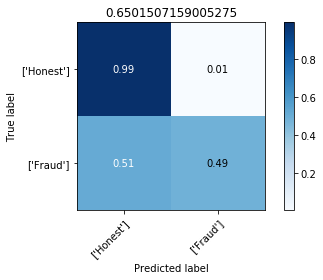

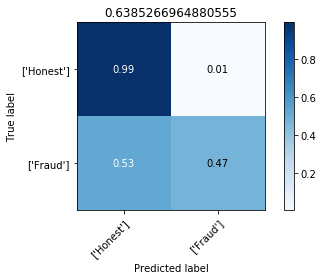

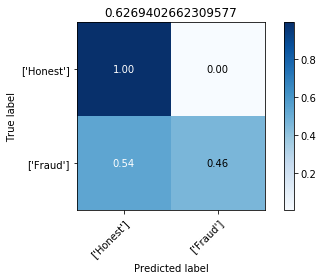

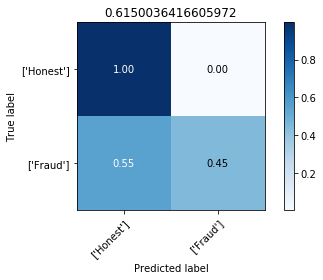

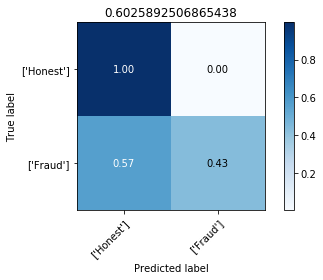

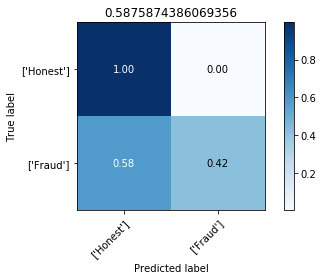

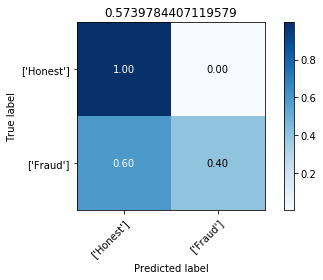

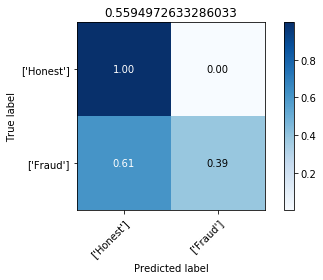

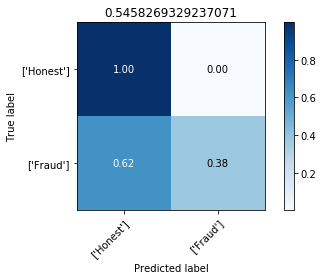

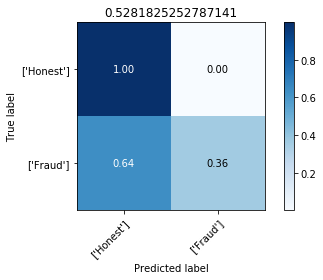

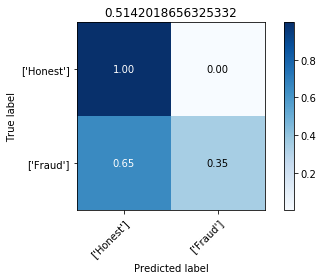

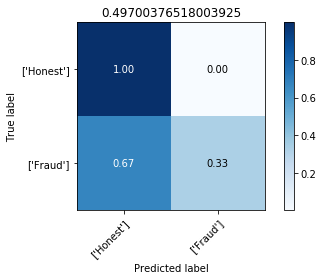

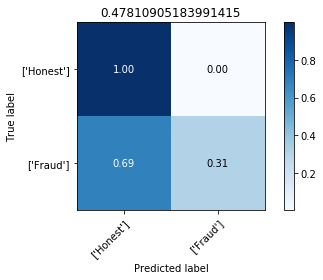

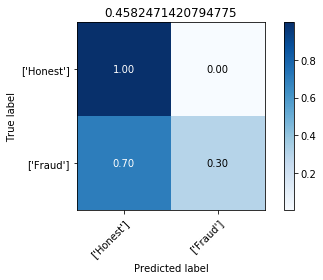

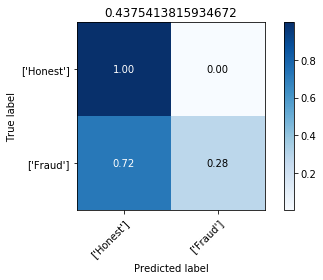

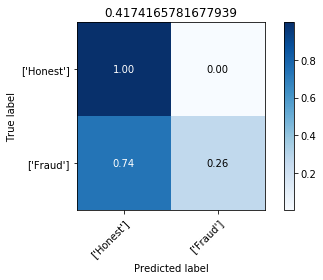

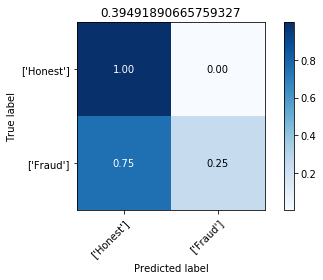

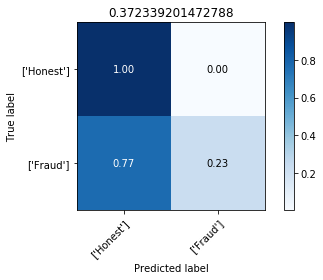

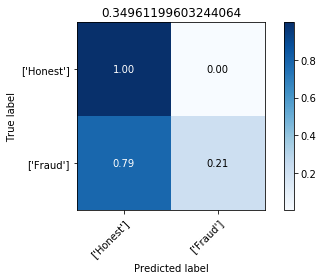

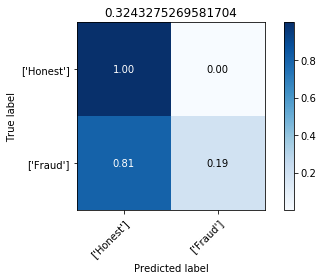

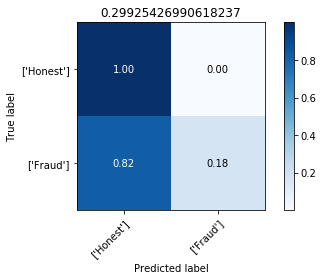

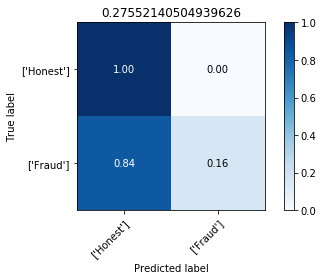

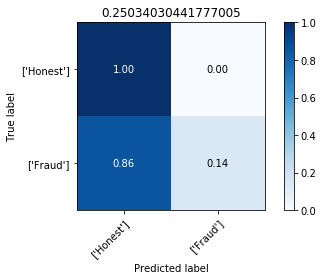

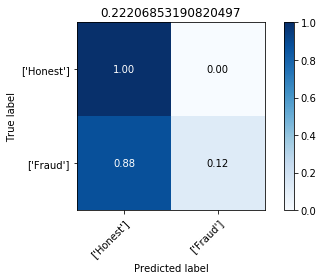

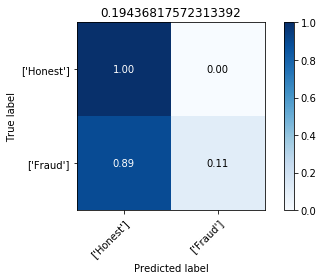

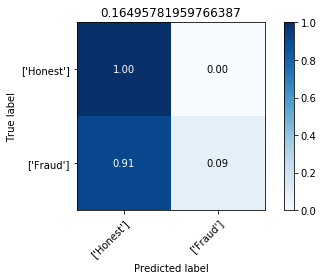

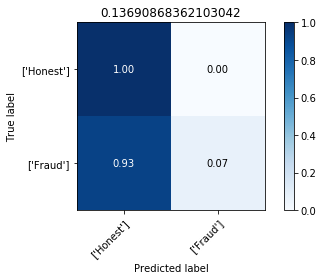

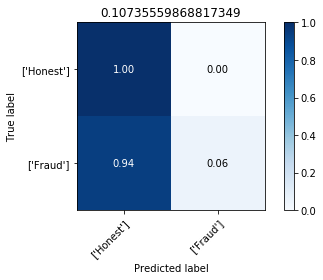

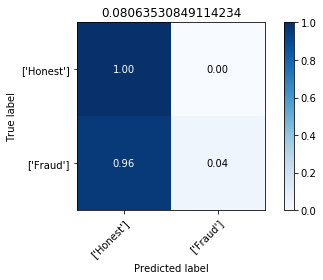

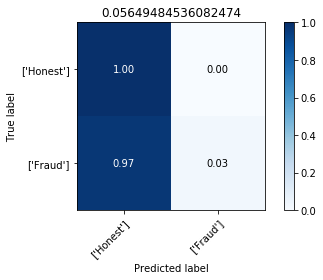

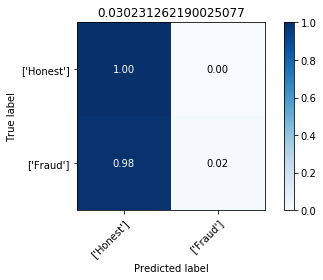

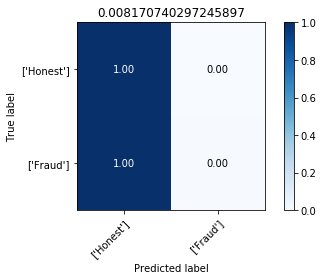

In [25]:
prob = np.ravel(model.predict_proba(x_data[0])[:,1])
threshold_list = np.arange(0.1,1,0.01)
precision,recall,f1,yprob = choosing_threshold(y_data[0],prob,threshold_list)

print('precision values: {}'.format(precision))
print('recall values: {}'.format(recall))
print('f1 values: {}'.format(f1))

for i in range(len(yprob)):
    plot_confusion_matrix(y_data[0], yprob[i],
                          classes = np.array([['Honest'],['Fraud']]),
                          normalize=True,
                          title= f1[i],
                          cmap=plt.cm.Blues)

In [26]:
y_hat = []
for i in range(len(x_data)):
    y_hat.append(predict_threshold(np.ravel(model.predict_proba(x_data[i])[:,1]),
                                   threshold_list[f1.index(max(f1))]))

Normalized confusion matrix
[[0.92388259 0.07611741]
 [0.19633637 0.80366363]]
Normalized confusion matrix
[[0.87476029 0.12523971]
 [0.29443327 0.70556673]]
Normalized confusion matrix
[[0.88399175 0.11600825]
 [0.29156869 0.70843131]]


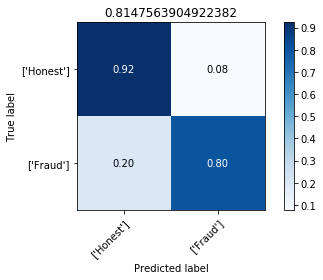

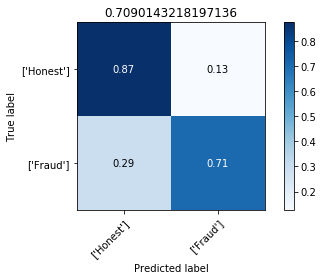

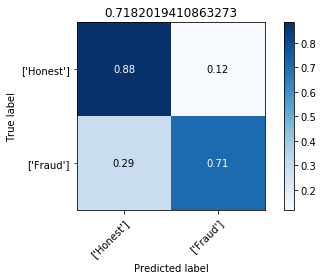

In [27]:
for i in range(len(y_hat)):
    plot_confusion_matrix(y_data[i], y_hat[i],
                          classes = np.array([['Honest'],['Fraud']]),
                          normalize=True,
                          title= f1_score(y_data[i],y_hat[i]),
                          cmap=plt.cm.Blues)